In [ ]:
# given field position, yard line, down, dist
# give prob(success) >half/distance
# give formation most likely of the successes
# find range of yards with prediction from rf

In [38]:
import pickle
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler # normalizing

# plots
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings("ignore")

# text stuff
from termcolor import colored

In [27]:
# load data and model
data = pd.read_pickle('data_more.pkl')
# trained model
rf = pd.read_pickle('rf_model.sav')
trainX = pd.read_pickle('trainX.pkl')
testX = pd.read_pickle('testX.pkl')

In [28]:
# label bins need to be in integers for neural network to get dummy variables for the label array
bin_int = {'-10 or less':0,
           '-9 to -4':1,
           '-3 to -1':2,
           '0 to 3':3,
           '4 to 7':4,
           '8 to 10':5,
           '11 to 15':6,
           '16 to 25':7,
           '26+':8}
data['yards_bin_int'] = data['yards_binned'].map(bin_int)
bin_yard_names = list(bin_int.keys())
# get labels
bin_trainy = data.loc[data['season'] != 2019]['yards_bin_int']
bin_testY = data.loc[data['season'] == 2019]['yards_bin_int']

In [30]:
print(data.shape)
print(trainX.shape)
print(testX.shape)

(682154, 143)
(509762, 15)
(172392, 15)


In [31]:
data = data.fillna(-999)
scaler = MinMaxScaler()
norm_data = scaler.fit_transform(data[list(trainX.columns)])

In [32]:
team_dict = {'ARZ': 'ARI',
            'CLV': 'CLE',
            'BLT':'BAL',
            'HST':'HOU'}
#map_abbr = {'ARI': 'ARZ', 'BAL': 'BLT', 'CLE': 'CLV', 'HOU': 'HST'}
for abb in data['hometeamabbr'].unique():
    team_dict[abb] = abb

In [33]:
data['fieldposition'] = data['fieldposition'].map(team_dict)

In [241]:
data['fieldposition'].unique()

array(['NE', 'KC', nan, 'BUF', 'NYJ', 'ATL', 'CHI', 'CIN', 'BAL', 'CLE',
       'PIT', 'ARI', 'DET', 'JAX', 'HOU', 'TEN', 'OAK', 'WAS', 'PHI',
       'LA', 'IND', 'GB', 'SEA', 'CAR', 'SF', 'DAL', 'NYG', 'NO', 'MIN',
       'DEN', 'LAC', 'TB', 'MIA'], dtype=object)

In [254]:
oi = data.loc[data['ownside']==1]
oi.loc[oi['possessionteam'] != oi['fieldposition']]

,gameid,playid,team,x,y,s,a,dis,orientation,dir,...,att_19,yds_19,td_19,1d_19,lng_19,y/a_19,y/g_19,fmb_19,yards_bin_int,ownside


In [34]:
# need to get a single field position variable
data['ownside'] = 0
data['ownside'].loc[data['possessionteam'] == data['fieldposition']] = 1 
#data['own'] = own_field(data['possessionteam'], data['fieldposition'])
#data[['possessionteam', 'fieldposition']].apply(own_field,axis = 1)

## Field Function

In [183]:
import matplotlib.patches as patches
# los = line of scrimmage
'''
function defines default parameters that can be turned on/off
returns rectangle that resembles the field
bottom left corner is (0,0)

parameters: 
    turn on/off 
        - line numbers 
        - endzones
        - highlighted los
        - fifty yard line as default los
    highlight_los_number = yard line of los
'''
def plot_field(linenumbers = True, # show numbers on the field
              endzones = True, # can turn endzones on/off
              highlight_los = False, # show line of scrimmage
              highlight_los_number = 50, # default line of scrimmage = 50
              highlighted_name = 'Line of Scrimmage',
              fifty_is_los = False, # use default line of scrimmage
              figsize = (12, 5.33)): # 1/10 scale of the 120 x 53.3
    # define the rectangle that is the field
    field = patches.Rectangle((0,0), 120, 53.3, linewidth = 0.1,
                             edgecolor = 'red',
                             facecolor = 'mediumspringgreen',
                             zorder = 0) # zorder = 0 - plot this first
    fig, ax = plt.subplots(1, figsize = figsize)
    # add the patch to the axes
    ax.add_patch(field)
    # define the field markers
    # first list is the x-coord, second is the y-coord 
    # the map together to plot vertical lines
    plt.plot([10, 10, 10, 20, 20, 30, 30, 40, 40, 50, 50, 60, 60, 70, 70, 80,
              80, 90, 90, 100, 100, 110, 110, 120, 0, 0, 120, 120], 
            [0, 0, 53.3, 53.3, 0, 0, 53.3, 53.3, 0, 0, 53.3, 53.3, 0, 0, 53.3,
              53.3, 0, 0, 53.3, 53.3, 0, 0, 53.3, 53.3, 53.3, 0, 0, 53.3],
            color = 'white')    
    # check for line of scrimmage
    if fifty_is_los:
        plt.plot([60,60], [0, 53.3], color = 'gold')
        plt.text(62, 50, '<- Line of Scrimmage', color = 'gold')
    # color the endzones so they stand out, if set to True
    if endzones:
        endzone1 = patches.Rectangle((0,0), 10, 53.3, # left endzone
                                    linewidth = 0.1,
                                    edgecolor = 'red',
                                    facecolor = 'gray', # color of endzone
                                    alpha = 0.8, # transparency
                                    zorder = 0)
        endzone2 = patches.Rectangle((110,0), 120, 53.3, # right endzone
                                    linewidth = 0.1,
                                    edgecolor = 'red',
                                    facecolor = 'gray',
                                    alpha = 0.8,
                                    zorder = 0)
        # add the patches to the endzones
        ax.add_patch(endzone1)
        ax.add_patch(endzone2)
        # set plot limits for the field
        plt.xlim(0, 120)
        plt.ylim(-5, 58.3) # a little extra padding on top and bottom
        plt.axis('off')
        # line numbers = True
        if linenumbers:
            for x in range(20, 110, 10): # start at the goalline and end on the goalline
                number = x
                # start with 20,30... once we get to midfield count backward
                if x > 50:
                    number = 120 - x
                # bottom numbers
                plt.text(x, 5, str(number - 10),
                        horizontalalignment = 'center',
                        fontsize = 12,
                        color = 'white')
                # top numbers
                plt.text(x - 0.95, 53.3 - 5, str(number - 10), # numbers are kind of off
                        horizontalalignment = 'center',
                        fontsize = 12,
                        color = 'white',
                        rotation = 180) # turn upside down to mimic a real field
    # set hash marks for middle of field and sidelines
    if endzones:
        hash_range = range(11, 110)
    else:
        hash_range = range(0, 120)
    # print the hash marks on each yard line
    for x in hash_range:
        ax.plot([x, x], [0.4, 0.7], color = 'white') #bottom sideline
        ax.plot([x, x], [53.0, 52.5], color = 'white') #top sideline
        ax.plot([x, x], [22.91, 23.57], color = 'white') # right hash - middle of field
        ax.plot([x, x], [29.73, 30.59], color = 'white') # left hash - middle of field
    # if highlight_los = True 
    if highlight_los:
        if highlight_los_number < 50:
            h1 = highlight_los_number + 10# account for the endzone
        else:
            h1 = highlight_los_number
        plt.plot([h1, h1], [0, 53.3], 
                 color = 'gold') # define from bottom to top
        plt.text(h1 + 2, 3.3, '<- {}'.format(highlighted_name), 
                 color = 'gold')
    
    return fig, ax

(<Figure size 864x383.76 with 1 Axes>,
 <matplotlib.axes._subplots.AxesSubplot at 0x1a2419ed10>)

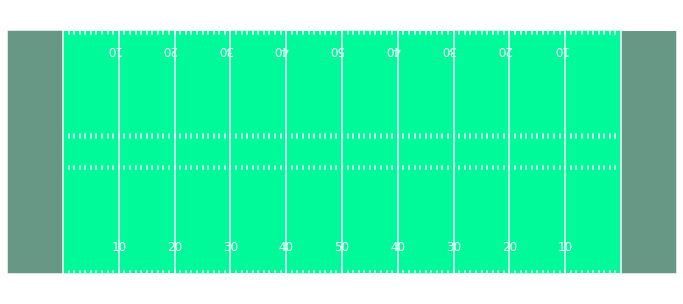

In [184]:
plot_field()

## Plot Play Info Function

In [297]:
def plot_info(ownside, yardline, down, distance, avg_yards, longest_run):
    '''
    want to plot on the field
    1. line of scrimmage
    2. first down marker
    3. avg yds gained
    '''
    # find the line of scrimmage
    if ownside == 1:
        los = yardline + 10
        first_down = los + distance
        los_x = los - 2
        #text_fd = yardline + distance
        #text_avg = int(yardline + avg_yards)
        if first_down > 50:
            text_fd = 100 - yardline - distance
        else:
            text_fd = yardline + distance
        if yardline + avg_yards > 50: 
            text_avg = int(100 - yardline - avg_yards)
        else:
            text_avg = int(yardline + avg_yards)
        if yardline + longest_run > 50: 
            text_lr = 100 - yardline - longest_run
        else:
            text_lr = yardline + longest_run
            
    else:
        los = 110 - yardline
        first_down = los + distance
        text_fd = yardline - distance
        text_avg = int(yardline - avg_yards)
        text_lr = int(yardline - longest_run)
        los_x = los - 2
    
    # set axes
    fig, ax = plot_field()    
    
    # plot line of scrimmage
    plt.vlines(x = los, ymin = 0, ymax = 53.3, 
               color = 'black', linestyle = 'dashed',
              zorder = 1)
    plt.text(x = los_x, y = 50,
            s = 'Line of Scrimmage ({}) -->'.format(yardline), 
             color = 'black', size = 15, horizontalalignment = 'right')
    # plot first down line
    plt.vlines(x = first_down, ymin = 0, ymax = 53.3,
              color = 'olive',
              zorder = 1)
    plt.text(x = first_down + 2, y = 26,
            s = '<-- First Down ({})'.format(text_fd), 
             color = 'olive', size = 15)
    # plot avg yards gained
    plt.vlines(x = los + avg_yards, ymin = 0, ymax = 53.3,
              color = 'darkred',
              zorder = 1)
    plt.text(x = los + avg_yards + 1/2, y = 15,
            s = '<-- Avg Result ({})\n {} yds'.format(text_avg, avg_yards), 
             color = 'darkred', size = 15)
    # plot longest run bar
    longest_run_bar = patches.Rectangle((los, 40), longest_run,
                                       5, linewidth = 0.1,
                                       edgecolor = 'crimson',
                                       facecolor = 'crimson',
                                       alpha = 1,
                                       zorder = 1)
    ax.add_patch(longest_run_bar)
    plt.text(x = los + longest_run + 2,
            y = 39, s = '({}) \n{} yds'.format(text_lr, longest_run),
            color = 'crimson', size = 15)
    plt.show()
    

In [298]:
#from collections import defaultdict, Counter # for the model

def play_to_choose():
    # check that down input is valid
    down = input('Enter the down of the play (1 - 4): ')
    try:
        down = int(down)
        if (down <= 4) and (down >= 1):
            down = down
        else:
            return print(colored('Psyche! Please enter a valid down', 'red'))
    except:
        return print(colored('Psyche! Please enter a valid down.', 'red'))
    # check that distance is valid
    distance = input('Enter the distance for a first down as an integer(1 - 99): ')
    try:
        distance = int(distance)
    except:
        return print(colored('Psyche! Please enter a valid distance.', 'red'))
    # check that ownside is valid
    ownside = input('Are you on your side of the field? (Y/N): ')
    try:
        if (ownside == 'Y') or (ownside == 'y'):
            ownside = 1
        elif (ownside == 'N') or (ownside == 'n'):
            ownside = 0
        else:
            return print(colored('Psyche! Please enter a Y or N.', 'red'))
    except:
        return print(colored('Psyche! Please enter a Y or N.', 'red'))
    # check yardline is valid
    yardline = input('Enter the yardline as an integer(1 - 50): ')
    try:
        yardline = int(yardline)
    except:
        return print(colored('Sike! Please enter a valid yardline.', 'red'))
    
    
    print('\nThanks for your input. Finding likely scenarios...')
    # check the scenario is in the data
    
    #try:
    df = data[(data['down'] == down)&(data['ownside'] == ownside)&(data['yardline'] == yardline)&(data['distance'] == distance)]       
    if df.shape[0] == 0:
        return print(colored('Those play conditions are not in our data.', 'red'))
    # normalize for prediction
    rf_df = scaler.fit_transform(df[list(trainX.columns)])
    
    #except:
     #   if df.shape[0] == 0:
      #      return print('Those play conditions are not in our data.')
    # predict yards with random forest
    y_pred = rf.predict(rf_df)
    for rng, bucket in bin_int.items():
        if bucket == y_pred[0]:
            pred = rng
    # get some play metrics
    runsuccess_prob = round(df['runsuccess'].sum()/len(df)*100,2)
    avg_yards = round(df['yards'].mean(),2)
    off_form = df['offenseformation'].value_counts().index[0]
    off_pers = df['offensepersonnel'].value_counts().index[0]
    # first down freq
    first = 0
    # td freq
    td = 0
    # loss of yards
    loss = 0
    # long run >13.5 yds
    long = 0
    for index, row in df.iterrows():
        if row['distance'] <= row['yards']:
            first += 1
        if (100 - row['yardfromowngoal']) <= row['yards']:
            td += 1
        if row['yards'] < 0:
            loss += 1
        if row['yards'] > 13.5:
            long += 1
    # first down probability
    first_pct = round(first/len(df)*100,2)
    # touchdown probability
    td_pct = round(td/len(df)*100,2)
    # loss probability
    loss_pct = round(loss/len(df)*100,2)
    # long run probability
    long_pct = round(long/len(df)*100,2)
    # result of the play
    if distance <= avg_yards:
        if ownside == 1:
        #df['possessionteam'].tolist()[0] != play_info['fieldposition'].tolist()[0]:
            result = 'Firstdown'
            new_dist = 10
        else:
            if yardline <= avg_yards:
                result = 'Touchdown'
                new_dist = 'Extra point'
            
            else:
                result = 'Firstdown'
                new_dist = 10
    else:
        result = str(df['down'].tolist()[0] + 1) + ' down'
        new_dist = df['distance'].tolist()[0] - int(avg_yards)
    # get longest run
    longest_run = max(df['yards'])
    # get colors - green = good, red = bad
    if avg_yards <= 3:
        yard_color = 'red'
    else:
        yard_color = 'green'
    if result == '4 down':
        result_color = 'red'
    else:
        result_color = 'green'
    try:
        if new_dist >= 7:
            new_dist_color = 'red'
        else:
            new_dist_color = 'green'
    except:
        new_dist_color = 'green'
    if longest_run <= 10:
        lr_color = 'red'
    else:
        lr_color = 'green'
    
    print('\nSample Size: ', colored(len(df)//22, 'blue'), 'plays')
    print('\nPredicted Yards Gained: ', colored(pred, 'blue'))
    print('\nLongest Run: ', colored(longest_run,lr_color), colored('yards', lr_color))
    #print('\nLikelihood of gaining half the required yards: ', runsuccess_prob, '%')
    #print('\nLikelihood of a first down: ', first_pct, '%')
    #print('\nLikelihood of a touchdown: ', td_pct, '%')
    print('\nAverage Yards Gained: ', colored(avg_yards, yard_color))
    print('\nMost Common Offensive Formation: ', colored(off_form, 'blue'))
    print('\nMost Common Offensive Personnel: ', colored(off_pers, 'blue'))
    print('\nMost Common Play Result: ', colored(result, result_color))
    print('\nDistance to First Down: ', colored(new_dist, new_dist_color))
    names = ['Run Success', 'First Down', 'TD', 'Long Run (>13.5)','Loss of Yards']
    stats = pd.DataFrame([runsuccess_prob, first_pct, td_pct ,long_pct, loss_pct], columns = ['stats'])
    stats['names'] = names
    sns.barplot(x = 'names', y = 'stats', data = stats, 
                color = 'tab:blue')
    for i in np.arange(2):
        plt.text(x = i,
                y = stats['stats'][i]-4,
                s = str(stats['stats'][i]) + '%',
                color = 'white',
                horizontalalignment='center')
    for i in np.arange(2,5):
        plt.text(x = i,
                y = stats['stats'][i]+2,
                s = str(stats['stats'][i]) + '%',
                horizontalalignment='center')
    plt.xlabel('Play Outcomes')
    plt.xticks(rotation = 30)
    plt.ylabel('')
    plt.ylim(0, max(stats['stats']) + 10)
    plt.title('Likelihood of Play Outcomes')
    plot_info(ownside, yardline, down, distance, avg_yards, longest_run)
    #print(df.loc[df['yards'] == max(df['yards'])][['possessionteam', 'fieldposition', 'yards', 'playdirection']])
    #return stats.head()

# Interactive for Coaches
1. Press Shift+Enter to run the command below
2. Follow the prompts, pressing enter after each input
3. Enjoy the results!

Enter the down of the play (1 - 4): 2
Enter the distance for a first down as an integer(1 - 99): 7
Are you on your side of the field? (Y/N): n
Enter the yardline as an integer(1 - 50): 26

Thanks for your input. Finding likely scenarios...

Sample Size:  11 plays

Predicted Yards Gained:  0 to 3

Longest Run:  13 yards

Average Yards Gained:  4.18

Most Common Offensive Formation:  SINGLEBACK

Most Common Offensive Personnel:  1 RB, 2 TE, 2 WR

Most Common Play Result:  3 down

Distance to First Down:  3


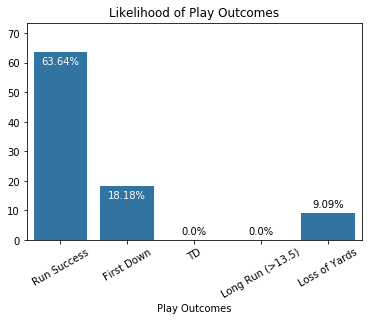

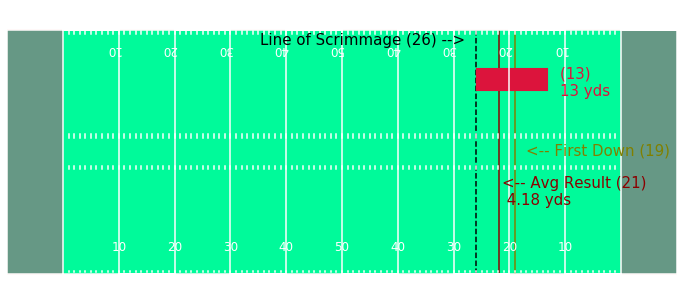

In [305]:
play_to_choose() 
